In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from surprise import BaselineOnly

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import KNNBasic
from surprise import CoClustering
from surprise import SlopeOne
from surprise import dump
from surprise.model_selection import GridSearchCV
import csv

In [3]:
csv_path = os.path.join("../data/csv/clean_reviews.csv")
TextFileReader = pd.read_csv(csv_path, chunksize=1000)  # the number of rows per chunk

dfList = []
for df in TextFileReader:
    dfList.append(df)

df = pd.concat(dfList,sort=False)

# df = pd.DataFrame()
# for chunk in pd.read_csv(csv_path, header=None, chunksize=1000):
#     df = pd.concat([df, chunk], ignore_index=True)


In [4]:
# The algorithm below reduces the memory size of a dataframe
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [5]:
props = df
props, NAlist = reduce_mem_usage(props)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 214.81125450134277  MB
******************************
Column:  Unnamed: 0
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  beer_id
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  score
dtype before:  float64
dtype after:  float32
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  122.74931526184082  MB
This is  57.14286970056009 % of the initial size
_________________

_________________

[]


In [6]:
df.head()

,Unnamed: 0,beer_id,username,score
0,1,125646,_dirty_,4.50
1,2,125646,CJDUBYA,4.75
2,3,125646,GratefulBeerGuy,4.58
3,4,125646,LukeGude,4.31
4,5,125646,jneff33,4.91


In [7]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [8]:
df.head()

,beer_id,username,score
0,125646,_dirty_,4.50
1,125646,CJDUBYA,4.75
2,125646,GratefulBeerGuy,4.58
3,125646,LukeGude,4.31
4,125646,jneff33,4.91


In [8]:
# Check upper rating 
df.max(axis=0)['score']

5.0

In [9]:
# Check upper rating 
df.min(axis=0)['score']

1.0

In [9]:
# Remove NAN
df2 = df.dropna()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8040830 entries, 0 to 8044494
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   beer_id   uint32 
 1   username  object 
 2   score     float32
dtypes: float32(1), object(1), uint32(1)
memory usage: 153.4+ MB


In [11]:
# How many beers in Df2?
df2['beer_id'].value_counts()

11757    17137
2093     15926
7971     14909
1093     14896
29619    14285
         ...  
28737       20
27885       20
65608       20
60708       20
72626       20
Name: beer_id, Length: 41463, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x3436C0A0>,
      dtype=object)

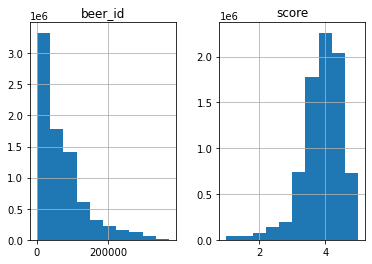

In [12]:
df2.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x33999FA0>,
      dtype=object)

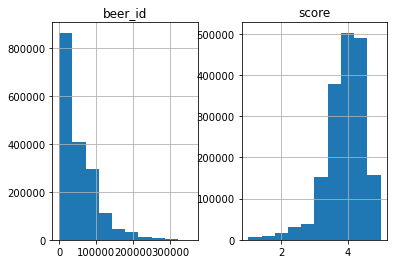

In [10]:
# Lets try to reduce/clean the dataset some more. Remove all beers rated less than 20 times
df3 = df2.sample(n=3000000)
df3 = df3.groupby('beer_id').filter(lambda x: len(x) > 100)
df3 = df3.groupby('username').filter(lambda x: len(x) > 20)
df3.hist()

In [14]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1786853 entries, 6607158 to 2752408
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   beer_id   uint32 
 1   username  object 
 2   score     float32
dtypes: float32(1), object(1), uint32(1)
memory usage: 34.1+ MB


In [27]:
df3.to_csv("../data/csv/clean_reviews_reduced.csv",index=False)

In [11]:
# A reader is needed but only the rating_scale param is requiered.
reader=Reader(rating_scale=(0,5))
# The columns must correspond to user id, item id and ratings (in that order). Names are irrelevent
data = Dataset.load_from_df(df3[['username', 'beer_id', 'score']], reader)

#### Try the SVD algorithm.  This gave us the best results before and will work with a large array

In [12]:
# sample random trainset and testset method
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE and MAE
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 0.3975
MAE:  0.2845


0.28445469900502474

In [16]:
#test_sample=['QuadriderMX', 19745, 4.25)]
print(algo.predict('QuadriderMX', 19745, 4.2))

user: QuadriderMX item: 19745      r_ui = 4.20   est = 3.51   {'was_impossible': False}


In [31]:
dump.dump('../data/csv/SVDFinal_Model', algo = algo, predictions=predictions)

MemoryError: 

In [17]:
# Code below identifes the top 10 best and worst predictions based upon code from this 
# notebook:https://nbviewer.jupyter.org/github/NicolasHug/Surprise/blob/master/examples/notebooks/KNNBasic_analysis.ipynb
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df_predict = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predict['Iu'] = df_predict.uid.apply(get_Iu)
df_predict['Ui'] = df_predict.iid.apply(get_Ui)
df_predict['err'] = abs(df_predict.est - df_predict.rui)
best_predictions = df_predict.sort_values(by='err')[:10]
worst_predictions = df_predict.sort_values(by='err')[-10:]   

In [18]:
# Best Predictions:
print(best_predictions)

                    uid     iid  rui  est                    details   Iu  \
181990  BearsDitkaBears   57747  5.0  5.0  {'was_impossible': False}   25   
341939        Brian1357  236710  5.0  5.0  {'was_impossible': False}   20   
121622         bombadil   62397  5.0  5.0  {'was_impossible': False}   48   
389098     DrunkyBuddha  120372  5.0  5.0  {'was_impossible': False}  103   
53766            CEDAMA   86172  5.0  5.0  {'was_impossible': False}  199   
158462     PC_Principal  112968  5.0  5.0  {'was_impossible': False}   75   
180241   Brocklanders34   88407  5.0  5.0  {'was_impossible': False}   28   
16854      DrunkyBuddha   47022  5.0  5.0  {'was_impossible': False}  103   
241029     DrunkyBuddha  125646  5.0  5.0  {'was_impossible': False}  103   
310472     PC_Principal   74295  5.0  5.0  {'was_impossible': False}   75   

          Ui  err  
181990  1577  0.0  
341939    66  0.0  
121622   339  0.0  
389098   186  0.0  
53766    756  0.0  
158462   236  0.0  
180241    76

In [19]:
# Worst Predictions
print(worst_predictions)

                    uid     iid   rui       est                    details  \
168180           Scalzo   86622  1.00  4.424004  {'was_impossible': False}   
185096      Travcofarms  100421  1.00  4.444080  {'was_impossible': False}   
367436  BearsDitkaBears   43687  1.00  4.452918  {'was_impossible': False}   
150722      robertm2152   80197  1.00  4.499604  {'was_impossible': False}   
336340       basickness   86012  1.00  4.514276  {'was_impossible': False}   
126157         OzmanBey     695  1.00  4.525633  {'was_impossible': False}   
71309          diemilio   72170  1.00  4.542440  {'was_impossible': False}   
214893   antichuckmoore    1320  5.00  1.429741  {'was_impossible': False}   
173935            BRD14   10672  1.00  4.619626  {'was_impossible': False}   
107577           Braden  110635  1.25  5.000000  {'was_impossible': False}   

         Iu    Ui       err  
168180   15   171  3.424004  
185096   97  1332  3.444080  
367436   25  1023  3.452918  
150722   34   692  3.

#### We have to reduce the dataset to work with KNN and other Models

In [20]:
# How many beers in Df3?
df3['beer_id'].value_counts()

11757    4223
2093     3911
1093     3757
29619    3507
19960    3418
         ... 
35409      77
49983      76
1606       76
3327       75
72597      69
Name: beer_id, Length: 5510, dtype: int64

In [21]:
# How many users in Df3?
df3['username'].value_counts()

djrn2             1443
kjkinsey          1382
Texasfan549       1378
jaydoc            1367
spycow            1360
                  ... 
ryan79              21
CRon_T              21
rphbrew             21
MattPittsburgh      21
thecrowing          21
Name: username, Length: 18054, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x3462E4D8>,
      dtype=object)

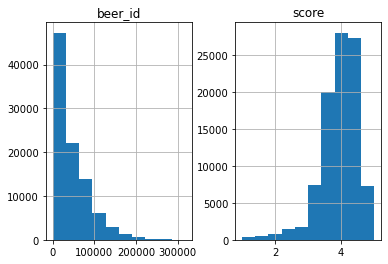

In [22]:
df4 = df2.sample(n=500000)
df4 = df4.groupby('beer_id').filter(lambda x: len(x) > 50)
df4 = df4.groupby('username').filter(lambda x: len(x) > 20)
df4.hist()

In [23]:
df4['beer_id'].value_counts()

29619     176
19960     174
11757     174
35036     172
10672     171
         ... 
136936     15
1484       15
90228      15
1317       15
76970      13
Name: beer_id, Length: 1898, dtype: int64

In [24]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94626 entries, 5729884 to 7412827
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   beer_id   94626 non-null  uint32 
 1   username  94626 non-null  object 
 2   score     94626 non-null  float32
dtypes: float32(1), object(1), uint32(1)
memory usage: 1.8+ MB


#### Try different models and see which is best

In [25]:
data = Dataset.load_from_df(df4[['username', 'beer_id', 'score']], reader)
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SlopeOne(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.393362,3.674492,0.237709
SlopeOne,0.449870,0.281588,1.003017
CoClustering,0.592253,2.104084,0.181835
